# Introduction

Thank you for taking our test! We look forward to reading your results.

- The test contains 2 sections. 
- You have 1 week to complete the test.
- We prefer if you use jupyter notebook to present your code and results. It is fine if you want to include additional libraries as separate python files. 
- If you don't have any python experience, you can use another language.

## Import libraries

In [206]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [207]:
pip install factor_analyzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [208]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from keras.models import Sequential
from keras.layers import Dense

In [209]:
!git clone https://github.com/laughingbud/conquer.git # clone github repo 

fatal: destination path 'conquer' already exists and is not an empty directory.


# Task 1

Given the below information
- X1, X2 and X3 are the predictors
- Y is the target variable

Identify how is Y related to X1, X2 and X3 and fill the Y cells from row 15,000 onwards

Please note that the relationship is **fully deterministic** but there is more than 1 relationship.

Output: 

Please provide the file ML_test1.csv with rows 1 to 19,998 and do not remove in-sample rows (which are from 1 to 14,999).
Also, explain the relationships between Y and X1, X2 and X3 in the notebook.

In [210]:
task1_data = pd.read_csv('conquer/ML_test1.csv',index_col=None)
task1_data.head()

,X1,X2,X3,Y
0,0.433278,-0.180904,-0.426411,0.614182
1,-0.461811,-0.204108,0.036119,-0.036119
2,-0.011897,-0.182808,0.256612,0.100000
3,-0.451108,-0.151159,-0.007978,0.007978
4,0.192973,-0.412564,0.107185,-0.112406


In [211]:
task1_data.describe()

,X1,X2,X3,Y
count,19995.000000,19995.000000,19995.000000,14998.000000
mean,-0.000960,0.002051,-0.000191,0.017811
std,0.287825,0.288636,0.289385,0.288890
min,-0.499993,-0.499913,-0.499972,-0.927212
25%,-0.247543,-0.245841,-0.250855,-0.202540
50%,-0.004666,0.001510,-0.002747,0.100000
75%,0.248101,0.253533,0.252823,0.193096
max,0.499999,0.499958,0.499930,0.969272


- We **observe** that variable Y data is continuous from row 0 until 14997 and has Nan starting row no. 14998. 
- Also the features have mean close to zero and even standard deviation and range are similar. This makes us conclude these features are already standardized.
- However predicted variable Y has a different range of values than features hence we will need to normalize all of the variables later.

Below we plot three individual scatter plots between each of the features vs the predicted variable to understand the relationship.

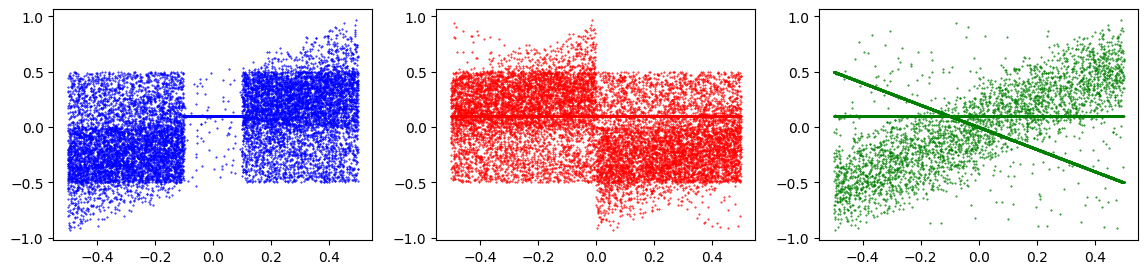

In [212]:
fig,ax = plt.subplots(1,3,figsize=(14,3))
ax[0].scatter(task1_data.X1,task1_data.Y,s=0.2,color='b')
ax[1].scatter(task1_data.X2,task1_data.Y,s=0.2,color='r')
ax[2].scatter(task1_data.X3,task1_data.Y,s=0.2,color='g')

From the scatter plot, we can see there has to be non-linear relationship and there are indeed multiple relationships likely. There are visible lines, boxes and other triangular like clusters.

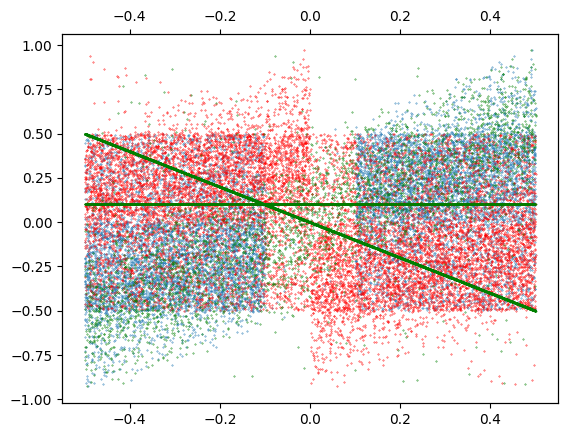

In [213]:
fig, ax = plt.subplots()
ay = ax.twiny()

ax.scatter(task1_data.X1, task1_data.Y,s=0.1)
ay.scatter(task1_data.X2, task1_data.Y, color='r',s=0.1)
ay.scatter(task1_data.X3, task1_data.Y, color='g',s=0.1)
plt.show()

In [214]:
task1_data.corr()

,X1,X2,X3,Y
X1,1.000000,-0.008958,-0.002757,0.459272
X2,-0.008958,1.000000,-0.008567,-0.289836
X3,-0.002757,-0.008567,1.000000,-0.344865
Y,0.459272,-0.289836,-0.344865,1.000000


- Correlation is very low amongst X1, X2 and X3, making them good candidates as independent variables to predict Y. So it makes us believe that there won't be a problem of multicollinearity. 
- Also we got a sense of how each of the predictors might likely be related to the predicted variable, atleast in terms of the direction if not the magnitude.

We conduct a couple of tests below to see if there's a need for Factor analysis. There could be one or two underlying factors driving the variation so we try and test for this. Since the predicted variable is on a different scale than the features, hence we transform the variables below for this particular analysis.

In [215]:
data_normal = preprocessing.StandardScaler().fit_transform(task1_data.iloc[:14998,:])
df = pd.DataFrame(data_normal, columns=[task1_data.columns])

In [216]:
# Bartlett's Test
chi_square_value, p_value = calculate_bartlett_sphericity(df.iloc[:,:3])
print("chi_square_value =", chi_square_value, "\np_value =", p_value)

chi_square_value = 3.3864438828429284 
p_value = 0.33579134254248066


Bartlett's test of sphericity checks whether the variables intercorrelate using the observed correlation matrix vs identity matrix. Since the p-value > 0.05, the test is not significant and conclude we should not conduct a factor analysis.

In [217]:
# Kaiser-Meyer-Olkin (KMO) Test
kmo_all, kmo_model = calculate_kmo(df.iloc[:,:3])
print("kmo_model =", kmo_model)

kmo_model = 0.4998840496946466


KMO tests indicates that around 50% of variance in our features is caused by underlying factors. This is neither high or low level and since Bartlett's test also indicated, there is no point in conducting factor analysis.

We conduct a few types of regression to see how the fit improves with the technique. First, we conduct a linear regression. Second is Decision trees approach. Third is neural networks (sequential model) approach and finally fourth is MLP regressor method.

### 1. Linear Regression

In [218]:
y = task1_data.iloc[:14998,:].Y.values
X = task1_data.iloc[:14998,:][['X1', 'X2', 'X3']].values

# X is the feature matrix and y is the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fit the model on the training data
regressor = LinearRegression()
regressor.fit(X_train, y_train)

reg_coeff = pd.DataFrame(regressor.coef_, index=['X1', 'X2', 'X3'], columns=['Reg_coeff'])
reg_coeff

,Reg_coeff
X1,0.455148
X2,-0.288109
X3,-0.345712


In [219]:
# Make predictions on the train data
y_train_pred = regressor.predict(X_train)

# Make predictions on the test data
y_pred = regressor.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)

# Print the mean squared error
print("Mean Squared Error: ", mse)

# R-Squared
#
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred),
                r2_score(y_test, y_pred)))

Mean Squared Error:  0.049196252327565214
R^2 train: 0.411, test: 0.419


The R-squared is low with this approach as from our observation of scatter plots we concluded there has to be a non-linear relation rather than linear. So the results here confirm our hypothesis. 

### 2. Decision trees approach

In [220]:
# X is the feature matrix and y is the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the decision tree model with max depth of 3
dt_model = DecisionTreeRegressor(max_depth=3)

# Fit the model on the training data
dt_model.fit(X_train, y_train)

# Make predictions on the train data
y_train_pred = dt_model.predict(X_train)

# Make predictions on the test data
y_pred = dt_model.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)

# Print the mean squared error
print("Mean Squared Error: ", mse)

# R-Squared
#
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred),
                r2_score(y_test, y_pred)))

Mean Squared Error:  0.028694829705103744
R^2 train: 0.656, test: 0.658


The R-squared improves significantly with this non-parametric approach as the decision trees can model non-linear relationship by partitioning the feature space. However, the fit still not very good so we explore other approaches.

### 3. Neural networks - Sequential

In [221]:
# Initialize model
model = Sequential()
model.add(Dense(32, input_dim=X.shape[1], activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae'])

# X is the feature matrix and y is the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Fit the model on the training data
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
329/329 [==============================] - 1s 2ms/step - loss: 0.0541 - mae: 0.1821
Epoch 2/100
329/329 [==============================] - 1s 2ms/step - loss: 0.0391 - mae: 0.1520
Epoch 3/100
329/329 [==============================] - 1s 2ms/step - loss: 0.0335 - mae: 0.1377
Epoch 4/100
329/329 [==============================] - 1s 2ms/step - loss: 0.0294 - mae: 0.1263
Epoch 5/100
329/329 [==============================] - 1s 2ms/step - loss: 0.0267 - mae: 0.1191
Epoch 6/100
329/329 [==============================] - 2s 5ms/step - loss: 0.0247 - mae: 0.1130
Epoch 7/100
329/329 [==============================] - 2s 5ms/step - loss: 0.0232 - mae: 0.1086
Epoch 8/100
329/329 [==============================] - 1s 4ms/step - loss: 0.0221 - mae: 0.1051
Epoch 9/100
329/329 [==============================] - 1s 3ms/step - loss: 0.0212 - mae: 0.1027
Epoch 10/100
329/329 [==============================] - 1s 3ms/step - loss: 0.0206 - mae: 0.1010
Epoch 11/100
329/329 [=================

In [222]:
# Get predicted y values for training data
y_train_pred = model.predict(X_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)

# Print the mean squared error
print("Mean Squared Error: ", mse)

# R-Squared
#
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred),
                r2_score(y_test, y_pred)))

141/141 [==============================] - 0s 1ms/step
Mean Squared Error:  0.011068527048541133
R^2 train: 0.864, test: 0.868


As you can see this neural network approach takes a lot more computing time and resources but achieves a quite high R-squared of around 88%. 

### 4. Neural networks - MLP regressor

In [223]:
mlp = MLPRegressor(random_state=2)
mlp.fit(X_train, y_train)

y_train_pred = mlp.predict(X_train)
# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)

# Print the mean squared error
print("Mean Squared Error: ", mse)
r2_train = r2_score(y_train, y_train_pred)
print("R-squared value for training data:", r2_train)

y_test_pred = mlp.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
print("R-squared value for test data:", r2_test)

Mean Squared Error:  0.011068527048541133
R-squared value for training data: 0.8200396554770661
R-squared value for test data: 0.8193206710442268


This approach combines multiple techniques to model non-linear relationship. However, we observe the R-squared dips a bit down to 82% in test data compared to the previous neural networks approach.

In [224]:
model.predict(task1_data[['X1', 'X2', 'X3']][14998:]).flatten()

157/157 [==============================] - 0s 1ms/step


array([ 0.24976692,  0.03517425,  0.3714448 , ..., -0.12379509,
        0.02658015, -0.49560153], dtype=float32)

In [225]:
task1_data.loc[task1_data.index>=14998,'Y'] = model.predict(task1_data[['X1', 'X2', 'X3']][14998:]).flatten()

157/157 [==============================] - 0s 1ms/step


In [226]:
task1_data.to_csv('./OUT_DV_ML_test1.csv',index=False)

In [227]:
task1_data

,X1,X2,X3,Y
0,0.433278,-0.180904,-0.426411,0.614182
1,-0.461811,-0.204108,0.036119,-0.036119
2,-0.011897,-0.182808,0.256612,0.100000
3,-0.451108,-0.151159,-0.007978,0.007978
4,0.192973,-0.412564,0.107185,-0.112406
...,...,...,...,...
19990,-0.096346,0.473540,0.335788,-0.140510
19991,0.446658,-0.099377,0.047888,0.334283
19992,-0.438806,0.348308,0.090290,-0.123795
19993,0.001773,-0.234236,0.143920,0.026580


### Conclusion

We took several regression based approaches from linear regression to Decision tree and finally a couple of neutral networks based. We observe that the best fit is achieved with the neural networks (Sequential) approach with R-squared over 87% in the test data. Since the objective here is to predict the Y variable without too much concern for overfitting and/or computational resources, we'll use neural networks approach to produce results.

# Task 2

We give you the following data: 

- Market data: the market data will be available after today market close. 
    - openadj/closeadj are open/close price adjusted for corporate actions
    - adv: average daily volume in dollars 
    - market cap: total market value in million dollars
    - sector info: the sector classification of the instruments in this universe
    - if the market cap is null for a stock for one day, the stock is out of the universe
- Other predictors: they might have different update frequency. The predictors are available before today market open. 
    - technical indicator: it is derived from market data
    - holding indicator: this is the total value in dollars held by a group of institutional investors
    - 2 accounting statement items: net income and sales in million dollars 
         - the net income is cumulative over the course of the fiscal year, i.e., Q2 amount is given as Q1 + Q2; Q4 amount is given as Q1 + Q2 + Q3 + Q4.
         - the sales figure is non-cumulative.

## Instructions
We expect you to 
1. **Process the data:** identify potential data issues and clean the data accordingly 
2. **Describe the data:** you should try to understand the data (e.g. overall distribution, time-series dynamics etc.)
3. **Design a prediction model:** you should try to predict future stock returns based on all information given. 
   - We prefer not to bet on market direction. Your model should avoid MARKET exposure.
   - We prefer not to bet on large vs small stocks. Your model should avoid SIZE exposure.
   - Be careful about look-ahead bias.
   - Be careful about the fact that small stocks are much more expensive to trade. You don't want your model to be good at predicting small stocks and very bad at predicting large ones
4. **Provide us with a final conclusion:** you should include statistics, a summary of your attempts and potential future ideas.

## Evaluation

You will be evaluated based on the following criteria:

- 20% - **Code quality**
- 20% - **Presentation of results and explanations.** We should be able to understand what you did without reading the code.
- 20% - **Data analysis skills**
- 10% - **Creativity**
- 10% - **Prediction accuracy**

Good luck!

### **Pre-process indicators data**

In [228]:
'''
Raw predictors
'''
financial_indicator = pd.read_csv('conquer/financial_indicator.csv', index_col=None)
technical_indicator = pd.read_csv('conquer/technical_indicator.csv', index_col=0)
holding_indicator = pd.read_csv('conquer/holding_indicator.csv', index_col=0)

Convert index into datetime for easier time series analysis and charting

In [229]:
technical_indicator.index = pd.to_datetime(technical_indicator.index)
holding_indicator.index = pd.to_datetime(holding_indicator.index)

Forward filling holdings for stocks as they are full of NaNs between the update dates

In [230]:
holding_indicator=holding_indicator.ffill()

In [231]:
financial_indicator.head()

,symbol,Date,FiscalQuarter,FiscalYear,NetIncome,GrossSales
0,666,2010-01-06,1.0,2010,-19.000000,996.533106
1,816,2010-01-12,3.0,2010,46094.097656,76823.496093
2,634,2010-01-20,4.0,2009,2389.096924,3981.828207
3,344,2010-01-21,4.0,2009,3534.000000,5890.000000
4,619,2010-01-21,4.0,2009,-60.200001,145.251285


**Financial Indicator processing steps**:
1. Create an applicable date ('appl_date') for the data which is the greater of the two dates i.e. input 'Date' and the applicable quarter end date.
2. Calculate sales as cumulative to make it comparable to NetIncome
3. Calculating margins as NetIncome/Gross sales to show profitability

In [232]:
# create a helper datetime column
financial_indicator['datetime'] = pd.to_datetime(financial_indicator['FiscalYear'].astype(str) + '-' + (3*financial_indicator['FiscalQuarter'].astype(int)).astype(str), format='%Y-%m')
# get quarter end date for each row
financial_indicator['quarter_end'] = financial_indicator['datetime'] + pd.offsets.QuarterEnd()
# Adjust the quarter end date to the nearest business day
financial_indicator['quarter_end'] = financial_indicator['quarter_end'] + pd.offsets.BDay(n=0)
# Drop the datetime column
financial_indicator=financial_indicator.drop(columns=['datetime'])  
financial_indicator.Date = pd.to_datetime(financial_indicator.Date)
# Create applicable date for the Net income and Gross sales reported
financial_indicator['appl_date'] = financial_indicator.apply(lambda x: x.quarter_end if x.quarter_end > x.Date else x.Date,axis=1)
# financial_indicator

In [233]:
financial_indicator = financial_indicator.sort_values(['symbol','FiscalYear', 'FiscalQuarter'])
financial_indicator['cumulative_sales'] = financial_indicator.groupby(['symbol','FiscalYear'])['GrossSales'].cumsum()
financial_indicator['Margin'] = financial_indicator.NetIncome / financial_indicator.cumulative_sales
financial_indicator.tail(2)

,symbol,Date,FiscalQuarter,FiscalYear,NetIncome,GrossSales,quarter_end,appl_date,cumulative_sales,Margin
7907,824,2021-12-01,3.0,2022,-547.794983,467.752037,2022-09-30,2022-09-30,1087.265397,-0.503828
8092,824,2022-03-02,4.0,2022,-679.947998,517.520138,2023-01-02,2023-01-02,1604.785535,-0.423700


We plot a histogram of financial indicator (margins) to identify how extreme are the outliers and trim them to a value

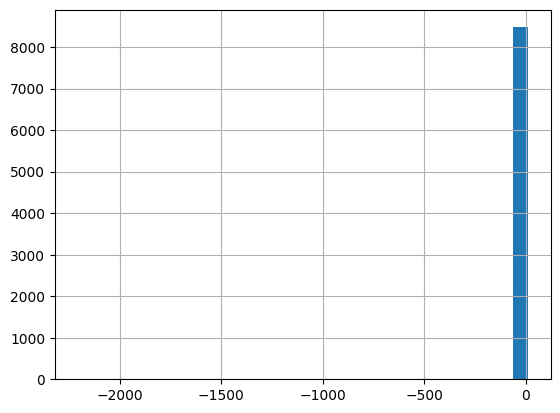

In [234]:
# plot the histogram of financial indicator
financial_indicator.Margin.hist(bins=30)
plt.show()

It appears there are negative outliers which may be due to smaller sales numbers and/or income when companies are starting up. We will clip the extreme values at +/-5.

In [235]:
# financial_indicator.loc[financial_indicator.Margin<-5,'Margin'] = 0
financial_indicator.Margin = financial_indicator.Margin.clip(-5,5)

We pivot the financial indicators data into the same format as our other two indicators. Forward fill the NaNs then resample and forward fill to the daily frequency.

In [236]:
financial_indicator_org = financial_indicator.pivot_table(index='appl_date', columns='symbol', values='Margin').ffill().resample('B').ffill()
financial_indicator_org.columns = financial_indicator_org.columns.astype(str)
financial_indicator_org.tail()

symbol,1,2,4,5,8,10,11,13,16,20,...,813,814,816,817,818,819,821,822,823,824
appl_date,,,,,,,,,,,,,,,,,,,,,
2022-12-27,0.298767,0.550304,0.024924,-0.138907,0.125292,0.079963,0.148919,-0.646022,0.073353,0.060662,...,0.055768,-0.125809,0.403711,0.063194,0.040757,0.134898,0.048289,0.040835,0.053657,-0.503828
2022-12-28,0.298767,0.550304,0.024924,-0.138907,0.125292,0.079963,0.148919,-0.646022,0.073353,0.060662,...,0.055768,-0.125809,0.403711,0.063194,0.040757,0.134898,0.048289,0.040835,0.053657,-0.503828
2022-12-29,0.298767,0.550304,0.024924,-0.138907,0.125292,0.079963,0.148919,-0.646022,0.073353,0.060662,...,0.055768,-0.125809,0.403711,0.063194,0.040757,0.134898,0.048289,0.040835,0.053657,-0.503828
2022-12-30,0.298767,0.550304,0.024924,-0.138907,0.125292,0.079963,0.148919,-0.646022,0.073353,0.060662,...,0.055768,-0.125809,0.403711,0.063194,0.040757,0.134898,0.048289,0.040835,0.053657,-0.503828
2023-01-02,0.298767,0.550304,0.024924,-0.138907,0.125292,0.079963,0.148919,-0.646022,0.073353,0.060662,...,0.055768,-0.125809,0.403711,0.063194,0.040757,0.134898,0.048289,0.040835,0.053657,-0.423700


In [237]:
# holding_indicator.describe()

### **Analysis of indicators**

**Indicator Charts** - We plot the indicators to see the cross sectional and time series variation and scale of the values to infer the need for normalizing variables.

<Axes: xlabel='appl_date'>

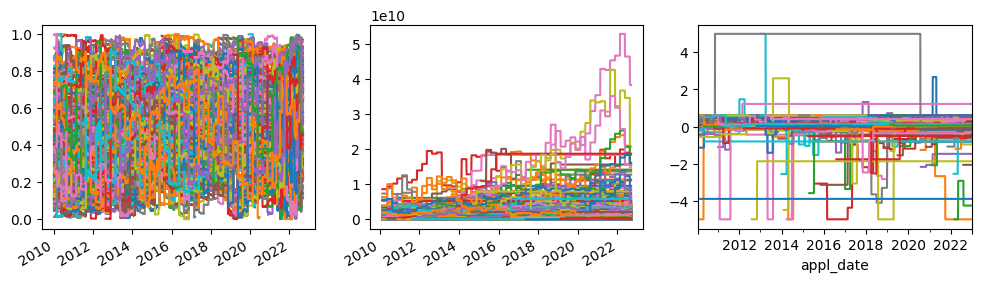

In [238]:
fig,ax = plt.subplots(1,3,figsize=(12,3))
technical_indicator.plot(legend=False,ax=ax[0])
holding_indicator.plot(legend=False,ax=ax[1])
financial_indicator_org.plot(legend=False,ax=ax[2])

**Observations**:
1. The technical indicator seem to be on a 0 to +1 scale and appear to be normalized already. 
2. However holding indicator appears to be raw and unscaled.
3. Financial indicator looks better after clipping the extreme values but is also raw and is not normalized.

**Autocorrelation checks**

1. Taking a (cross sectional) median value of raw indicators over time and running an autocorrelation and partial-autocorrelation on their weekly (Technical), monthly (Holding) and quarterly (Financial), respectively, mean values.
2. We also run ACF on first difference of the above series to remove any trend that might be present.

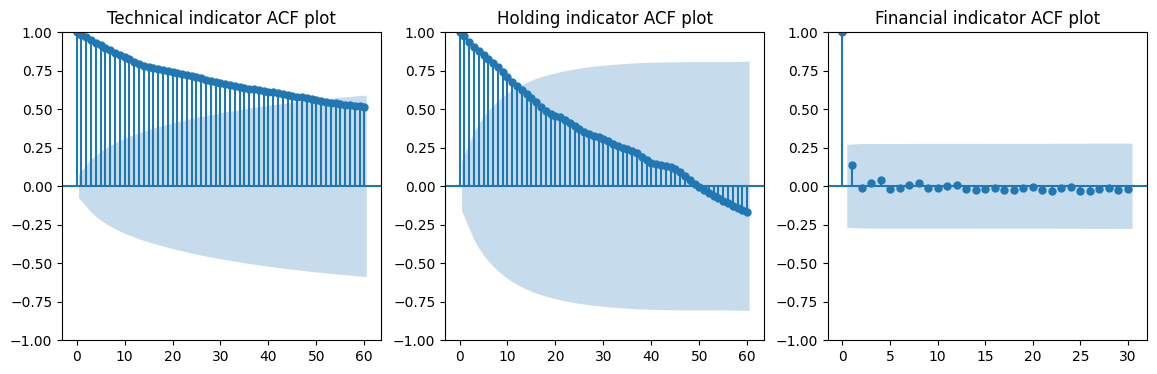

In [239]:
fig,ax = plt.subplots(1,3,figsize=(14,4))
sm.graphics.tsa.plot_acf(technical_indicator.median(axis=1).dropna().resample('W').mean(),title='Technical indicator ACF plot',lags=60,ax=ax[0])
sm.graphics.tsa.plot_acf(holding_indicator.median(axis=1).dropna().resample('M').mean(),title='Holding indicator ACF plot',lags=60,ax=ax[1])
sm.graphics.tsa.plot_acf(financial_indicator_org.median(axis=1).dropna().resample('Q').mean(),title='Financial indicator ACF plot',lags=30,ax=ax[2])
plt.show()

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


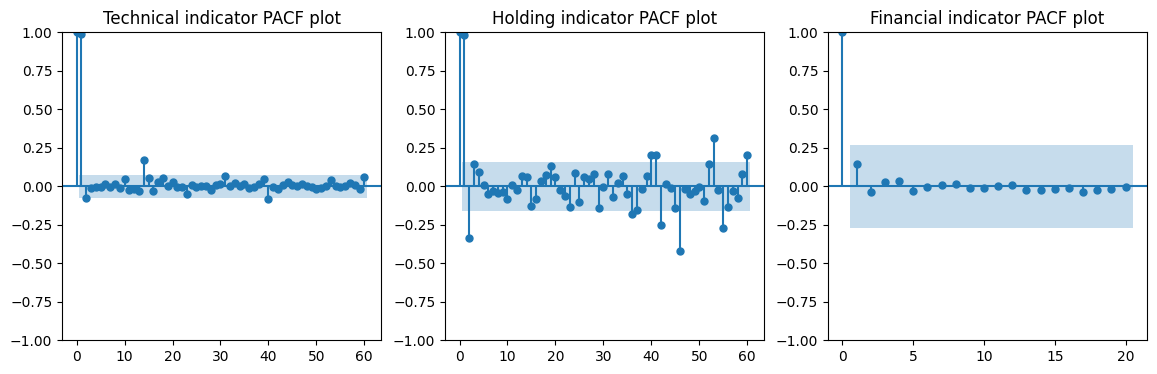

In [240]:
fig,ax = plt.subplots(1,3,figsize=(14,4))
sm.graphics.tsa.plot_pacf(technical_indicator.median(axis=1).dropna().resample('W').mean(),title='Technical indicator PACF plot',lags=60,ax=ax[0])
sm.graphics.tsa.plot_pacf(holding_indicator.median(axis=1).dropna().resample('M').mean(),title='Holding indicator PACF plot',lags=60,ax=ax[1])
sm.graphics.tsa.plot_pacf(financial_indicator_org.median(axis=1).dropna().resample('Q').mean(),title='Financial indicator PACF plot',lags=20,ax=ax[2])
plt.show()

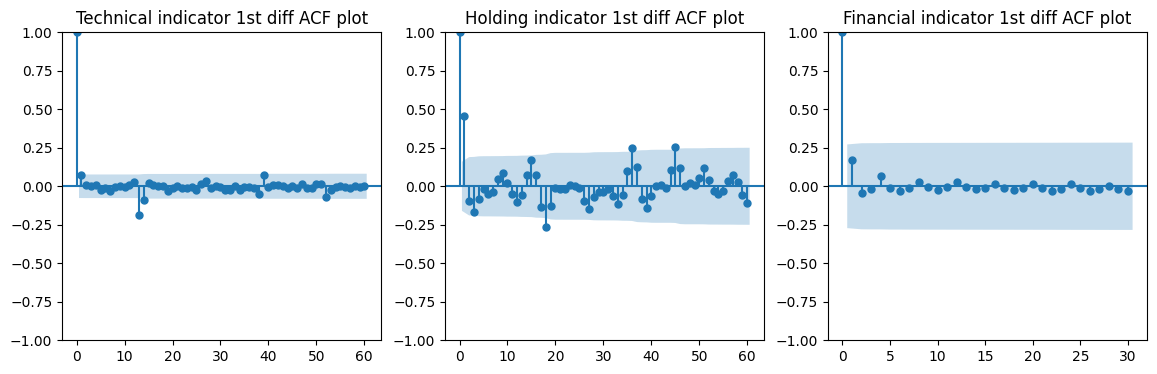

In [241]:
fig,ax = plt.subplots(1,3,figsize=(14,4))
sm.graphics.tsa.plot_acf(technical_indicator.median(axis=1).dropna().resample('W').mean().diff(1).dropna(),title='Technical indicator 1st diff ACF plot',lags=60,ax=ax[0])
sm.graphics.tsa.plot_acf(holding_indicator.median(axis=1).dropna().resample('M').mean().diff(1).dropna(),title='Holding indicator 1st diff ACF plot',lags=60,ax=ax[1])
sm.graphics.tsa.plot_acf(financial_indicator_org.median(axis=1).dropna().resample('Q').mean().diff(1).dropna(),title='Financial indicator 1st diff ACF plot',lags=30,ax=ax[2])
plt.show()

**Observations**:
1. The technical and holding indicators appear to show significant autocorrelation in short term but then there is a reversal afterwards.
2. Technical indicator has significant PACF at 1st week lag then a reversal in 2nd week lag. Holdings indicator has significant PACF at 1st month lag then a reversal in 2nd month lag.
3. Financial indicator is resampled quarterly, as opposed to others which is its natural frequency, and doesn't show much autocorrelation.
4. There is significant trend in holding indicator as observed from 1st diff autocorrelation.

### **Pre-process market data**

In [242]:
'''
Market data
'''
op = pd.read_csv('conquer/openadj.csv',index_col=0)
cp = pd.read_csv('conquer/closeadj.csv',index_col=0) 
adv = pd.read_csv('conquer/adv.csv',index_col=0)
cap = pd.read_csv('conquer/market_cap.csv',index_col=0)
sector = pd.read_csv('conquer/sectors.csv', index_col=0)

<ipython-input-242-6e54d395dfcc>:8: DtypeWarning: Columns (1,2,3,4,6,7,8,10,11,12,13,14,15,16,20,23,27,28,30,31,32,35,40,43,44,45,46,47,48,49,50,51,52,53,54,56,57,60,61,62,67,69,71,72,74,77,81,82,83,87,89,90,95,99,100,101,102,104,106,107,108,109,114,115,117,118,120,121,122,125,126,127,130,132,135,136,137,140,143,145,147,149,150,152,154,155,156,159,161,165,166,167,169,170,171,173,174,175,177,179,181,182,183,185,187,189,190,194,196,197,199,200,202,203,206,207,209,211,212,213,214,215,216,217,218,220,221,224,226,230,232,233,234,235,236,237,238,240,242,243,244,245,246,247,248,249,250,251,252,254,258,259,260,261,263,264,265,267,268,269,270,271,272,273,275,276,277,278,279,280,282,283,284,285,286,288,289,290,291,292,293,294,298,300,301,302,303,304,305,306,308,309,310,311,312,313,314,315,316,317,318,319,320,321,323,325,326,327,328,329,330,331,332,335,336,337,338,339,340,342,343,344,346,347,348,349,350,351,352,354,355,356,357,358,361,362,363,364,366,367,368,369,370,371,372,373,374,375,376,377,37

Convert index into datetime

In [243]:
op.index = pd.to_datetime(op.index)
cp.index = pd.to_datetime(cp.index)
adv.index = pd.to_datetime(adv.index)
cap.index = pd.to_datetime(cap.index)
sector.index = pd.to_datetime(sector.index)

Plotting a chart below of closing prices for a random period and random set of stocks.

<Axes: >

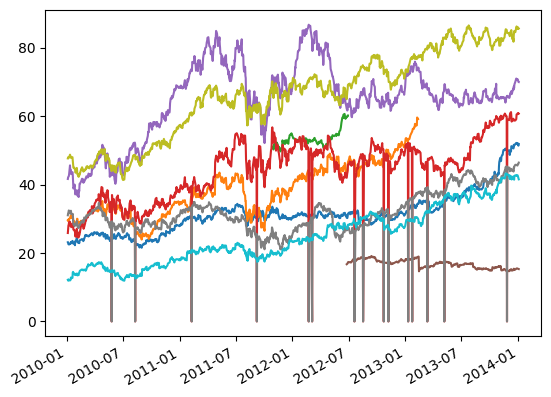

In [244]:
cp.iloc[:1000,50:60].plot(legend=False)

In [245]:
# op.head()

From **observation**, there are many instances of prices dipping to zero suddenly. We will treat this by taking a mean of the previous and the next observed price. We also clip large jump in prices by capping any consecutive diff in prices upto 3 standard deviation in price difference.

In [246]:
def clean_price(df,func,level):
    if func == 'trim': # Set threshold to 3 standard deviations
        threshold = level * df.diff().std() 
        mask = df.diff().abs() >= threshold
    elif func == 'replace':
        mask = df==np.zeros(df.shape[1])
        # df_locs = np.where(df==np.zeros(df.shape[1]))
    else:
        print('Error! Please specify trim or replace.')
        return

    locs = np.where(mask)
    for i in range(len(locs[0])):
        row, col = locs[0][i], locs[1][i]
        up_row = row-1 if row == cp.shape[0]-1 else row+1
        df.iloc[row, col] = (df.iloc[row-1, col] + df.iloc[up_row, col])/2
    return df

In [247]:
cp=clean_price(cp,func='replace',level=0)
op=clean_price(op,func='replace',level=0)
cp=clean_price(cp,func='trim',level=3)
op=clean_price(op,func='trim',level=3)

Calculate returns using clean closing and opening prices of stocks below.

In [248]:
rets = (cp-op)/op
rets.tail()

,0,1,2,3,4,5,6,7,8,9,...,815,816,817,818,819,820,821,822,823,824
2022-09-02,NaN,NaN,NaN,NaN,0.000683,NaN,-0.036908,NaN,-0.027802,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.020255,-0.008691,NaN,-0.020057
2022-09-06,NaN,NaN,NaN,NaN,0.000536,NaN,-0.021017,NaN,-0.007619,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.017199,-0.022777,NaN,-0.001176
2022-09-07,NaN,NaN,NaN,NaN,0.017691,NaN,0.004669,NaN,0.014446,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.018750,0.041065,NaN,0.041054
2022-09-08,NaN,NaN,NaN,NaN,0.032423,NaN,0.034362,NaN,0.010671,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.021040,0.027464,NaN,0.023845
2022-09-09,NaN,NaN,NaN,NaN,0.046801,NaN,0.016899,NaN,0.006226,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000714,0.010455,NaN,0.039092


In [249]:
# rets.fillna(0).plot(legend=False)

In [250]:
# adv.head()

In [251]:
cap.head()

,0,1,2,3,4,5,6,7,8,9,...,815,816,817,818,819,820,821,822,823,824
2010-01-04,NaN,NaN,2209.77,1465.07,84235.38,NaN,NaN,14292.50,17611.95,1417.18,...,NaN,32553.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,2177.43,1470.80,83508.41,NaN,NaN,14088.75,17469.89,1467.25,...,NaN,32680.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,2177.43,1480.56,84065.23,NaN,NaN,14045.40,17349.03,1443.86,...,NaN,32181.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,2196.15,1481.96,84699.39,NaN,NaN,14504.91,17228.16,1431.14,...,NaN,31200.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,2174.02,1482.18,85101.55,NaN,NaN,14171.11,17355.39,1467.66,...,NaN,31280.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We create a universe ('cap_univ') variable to represent the universe as stocks join or exit the group based on their market cap variation.

In [252]:
cap_univ = cap.copy(deep=True)
cap_univ = cap_univ.fillna(0)
cap_univ = cap_univ.applymap(lambda x: 1 if x > 0 else x)
# cap_univ

In [263]:
sector.tail()

,0,1,2,3,4,5,6,7,8,9,...,815,816,817,818,819,820,821,822,823,824
2022-09-02,NaN,NaN,NaN,NaN,Health Care,NaN,Information Technology,NaN,Materials,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Materials,Materials,NaN,Information Technology
2022-09-06,NaN,NaN,NaN,NaN,Health Care,NaN,Information Technology,NaN,Materials,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Materials,Materials,NaN,Information Technology
2022-09-07,NaN,NaN,NaN,NaN,Health Care,NaN,Information Technology,NaN,Materials,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Materials,Materials,NaN,Information Technology
2022-09-08,NaN,NaN,NaN,NaN,Health Care,NaN,Information Technology,NaN,Materials,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Materials,Materials,NaN,Information Technology
2022-09-09,NaN,NaN,NaN,NaN,Health Care,NaN,Information Technology,NaN,Materials,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Materials,Materials,NaN,Information Technology


In [254]:
sector_list = pd.Series(sector.stack().unique())
sector_list=sector_list.to_list()
sector_list

['Information Technology',
 'Consumer Discretionary',
 'Health Care',
 'Materials',
 'Industrials',
 'Energy',
 'Utilities',
 'Financials',
 'Consumer Staples',
 'Communication Services',
 'Real Estate']

In [255]:
# rets.fillna(0).iloc[:,:100].plot(legend=False)

In [256]:
# rets.fillna(0).iloc[:,:100].plot(legend=False)

Below, we create a few functions that will immensely help in our cross sectional and time series analysis.
1. tscore is for time series scoring of a series using input half life
2. xscore is to cross sectionally score the stocks for any given date
3. ret2pi is to create a log price (cumulative return) index of how a series evolves over time

In [257]:
def tscore(df,halflife,demean=True):
    df.sort_index(axis=0,inplace=True)
    dfmean = df.ewm(halflife=halflife).mean()
    dfstd = df.ewm(halflife=halflife).std()
    if demean:
        return (df-dfmean)/dfstd,dfmean,dfstd
    else:
        return df/dfstd,dfmean,dfstd


In [258]:
def xscore(df):
    ndims = df.ndim
    if ndims == 2:
        return df.sub(df.mean(axis=1),axis=0).div(df.std(axis=1),axis=0)
    elif ndims==3:
        return df.sub(df.mean(axis=1,level=1),axis=0).div(df.std(axis=1,level=1),axis=0)
    else:
        print('Error! The number of dimensions should be 2 or max 3.')

In [259]:
def ret2pi(df):
    return np.log(df+1).cumsum().fillna(method='ffill')

### **Returns testing**

We test by betting in the direction of all the three indicators for each stock and aggregating the (scores*returns) up to see how the cumulative return evolves over time and if it can be used to time the market.

In [260]:
sm_hl = 5
ts_hl = 260
xs_ti_sig = xscore(technical_indicator.ewm(halflife=sm_hl).mean()).clip(-3,3)
xs_hi_sig = xscore(holding_indicator.ewm(halflife=sm_hl).mean()).clip(-3,3)
xs_fi_sig = xscore(financial_indicator_org.ewm(halflife=sm_hl).mean()).clip(-3,3)
ts_ti_sig = xscore(tscore(technical_indicator.ewm(halflife=sm_hl).mean(),ts_hl)[0]).clip(-3,3)
ts_hi_sig = xscore(tscore(holding_indicator.ewm(halflife=sm_hl).mean(),ts_hl)[0]).clip(-3,3)
ts_fi_sig = xscore(tscore(financial_indicator_org.ewm(halflife=sm_hl).mean(),ts_hl)[0]).clip(-3,3)

In [287]:
# for sec in sector_list:
#     print(rets[sector.columns[sector[sector==sec].any()]].sum(axis=1))

<Axes: title={'center': 'Fundamental indicator TS & XScored'}>

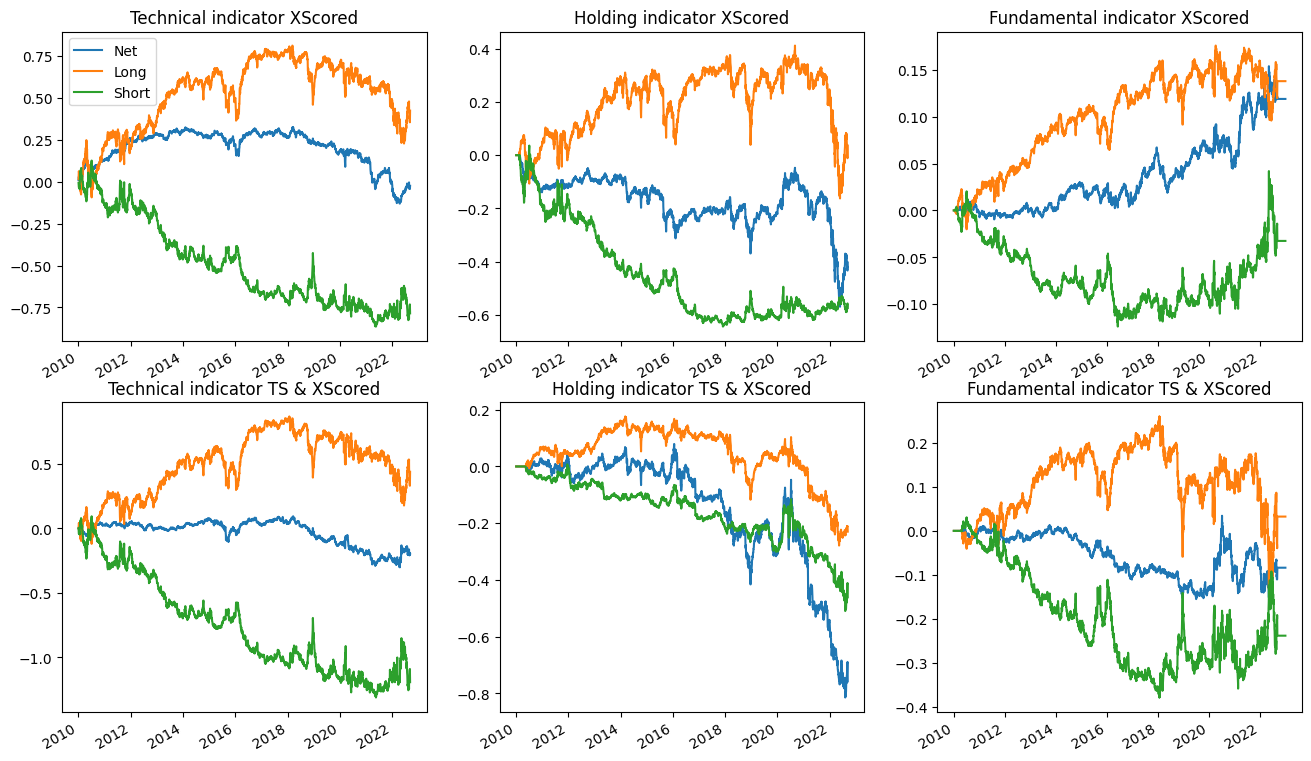

In [280]:
fig,ax = plt.subplots(2,3,figsize=(16,10))
ret2pi(xs_ti_sig.mul(rets).div(100).sum(axis=1)).plot(ax=ax[0,0],title='Technical indicator XScored')
ret2pi(xs_ti_sig[xs_ti_sig>0].mul(rets).div(100).sum(axis=1)).plot(ax=ax[0,0],title='Technical indicator XScored')
ret2pi(xs_ti_sig[xs_ti_sig<0].mul(rets).div(100).sum(axis=1)).plot(ax=ax[0,0],title='Technical indicator XScored')
ax[0,0].legend(["Net", "Long", "Short"]);
ret2pi(xs_hi_sig.mul(rets).div(100).sum(axis=1)).plot(ax=ax[0,1],title='Holding indicator XScored')
ret2pi(xs_hi_sig[xs_hi_sig>0].mul(rets).div(100).sum(axis=1)).plot(ax=ax[0,1],title='Holding indicator XScored')
ret2pi(xs_hi_sig[xs_hi_sig<0].mul(rets).div(100).sum(axis=1)).plot(ax=ax[0,1],title='Holding indicator XScored')
ret2pi(xs_fi_sig.mul(rets[financial_indicator_org.columns]).div(100).sum(axis=1)).plot(ax=ax[0,2],title='Fundamental indicator XScored')
ret2pi(xs_fi_sig[xs_fi_sig>0].mul(rets[financial_indicator_org.columns]).div(100).sum(axis=1)).plot(ax=ax[0,2],title='Fundamental indicator XScored')
ret2pi(xs_fi_sig[xs_fi_sig<0].mul(rets[financial_indicator_org.columns]).div(100).sum(axis=1)).plot(ax=ax[0,2],title='Fundamental indicator XScored')
ret2pi(ts_ti_sig.mul(rets).div(100).sum(axis=1)).plot(ax=ax[1,0],title='Technical indicator TS & XScored')
ret2pi(ts_ti_sig[ts_ti_sig>0].mul(rets).div(100).sum(axis=1)).plot(ax=ax[1,0],title='Technical indicator TS & XScored')
ret2pi(ts_ti_sig[ts_ti_sig<0].mul(rets).div(100).sum(axis=1)).plot(ax=ax[1,0],title='Technical indicator TS & XScored')
ret2pi(ts_hi_sig.mul(rets).div(100).sum(axis=1)).plot(ax=ax[1,1],title='Holding indicator TS & XScored')
ret2pi(ts_hi_sig[ts_ti_sig>0].mul(rets).div(100).sum(axis=1)).plot(ax=ax[1,1],title='Holding indicator TS & XScored')
ret2pi(ts_hi_sig[ts_ti_sig<0].mul(rets).div(100).sum(axis=1)).plot(ax=ax[1,1],title='Holding indicator TS & XScored')
ret2pi(ts_fi_sig.mul(rets[financial_indicator_org.columns]).div(100).sum(axis=1)).plot(ax=ax[1,2],title='Fundamental indicator TS & XScored')
ret2pi(ts_fi_sig[ts_fi_sig>0].mul(rets[financial_indicator_org.columns]).div(100).sum(axis=1)).plot(ax=ax[1,2],title='Fundamental indicator TS & XScored')
ret2pi(ts_fi_sig[ts_fi_sig<0].mul(rets[financial_indicator_org.columns]).div(100).sum(axis=1)).plot(ax=ax[1,2],title='Fundamental indicator TS & XScored')

**Observations**: 
1. It appears that the holding indicator works in the opposite direction as the returns, with strong returns coming from timing (time series) part. 
2. However, Fundamental indicator bets on the returns in the same direction, for example positive score expects returns to be positive. Here we'd expect tilt rather than timing to play crucial role in long term returns.
3. While Technical indicator seems like mixed bag but I would bet on the opposite direction as technical indicator to start with due to a strong time series effect at display there in second half.

**Caveat**
- The obvious caveat is that we have run the scores against the returns, rather than holdings. Obviously risk model will play at role, depending on covariance and risk of stocks, at scaling/optimizing these scores to respective holdings. So the real effect on portfolio returns and IR would be seen then, but here we can draw top level observation based on signal scores and their play with returns.

## Backtesting

## Set up risk model and optimization

The aim is to build risk model and optimize targeting 1% ex-ante risk allowing stocks to go long and short. Given the time constraint, leaving this step incomplete.

In [262]:
# from cvxpy import *

# # Step 1: Define the universe of stocks and import historical price data and risk factor data.
# stock_universe = cap_univ 

# # Step 2: Calculate the returns and risk of each stock using historical price data and risk factor data.
# returns_data = rets 
# risk_data = rets.std()

# # Step 3: Implement a portfolio construction algorithm that maximizes returns while constraining active risk to 1%.
# def optimize_portfolio(returns, risk, asset_universe):
#     n_assets = len(returns.columns)
#     mu = returns.mean().values
#     Sigma = returns.cov().values
#     w = Variable(n_assets)
#     risk_target = Parameter(nonneg=True)
#     objective = Maximize(mu.T * w)
#     constraints = [sum(w) == 1, norm(Sigma @ w, 2) <= risk_target, w >= 0, w <= asset_universe.values[-1]]
#     prob = Problem(objective, constraints)
#     risk_target.value = 0.01
#     prob.solve()
#     weights = np.asarray(w.value).reshape(-1)
#     return weights

# # Step 4: Backtest the portfolio by simulating trading using historical data.
# portfolio_value = []
# portfolio_weights = []
# portfolio_returns = []
# risk_target = 0.01
# for date in returns_data.index:
#     # Select the stocks in the asset universe at this date
#     # asset_universe = stock_universe.loc[date]
#     asset_universe = stock_universe.columns[stock_universe.loc[date]==1]
#     # Calculate the expected returns and covariance matrix for the selected stocks
#     # selected_returns = returns_data.loc[date, asset_universe.values]
#     # selected_returns = returns_data.mul(stock_universe).loc[date, :]
#     selected_returns = returns_data.loc[date, stock_universe.columns[stock_universe.loc[date]==1]].to_frame().T
#     # selected_cov = selected_returns.cov()
#     selected_cov = rets.cov()

#     # Optimize the portfolio
#     weights = optimize_portfolio(selected_returns, selected_cov, asset_universe)
#     print(weights)
#     # Calculate the portfolio returns and add to the list
#     portfolio_returns.append(np.dot(selected_returns, weights))

#     # Update the portfolio value based on the returns
#     if len(portfolio_value) == 0:
#         portfolio_value.append(1000000)
#     else:
#         portfolio_value.append(portfolio_value[-1] * (1 + portfolio_returns[-1]))

#     # Add the portfolio weights to the list
#     portfolio_weights.append(weights)


## **Conclusion**

Finally, if haven't had limited time, would have ideally liked to complete the risk model and backtesting section to back out the actual historical holdings and alphas.
I think all three (technical, holding and fundamental) indicators can be good candidates for further signal research as in my work they have shown predictability of stock returns in long and short bets.

Potential future ideas:
- Sector bets and within sector bets

Empirics:
1. Cumulative Performance by bucket (percentile)
2. Lead lag IR plot
3. Tilt vs timing decomposition of IR
4. Lagged Performance - Effects of lags on IR 
5. Smoothed holding performance - Effect of smoothing